# PyTorch TabNet Fraud Classification

This notebook implements a fraud detection classifier using FT-Transformer on balanced training data.

## Objectives:
1. Load and prepare balanced fraud detection datasets
2. Build and train a FT-Transformer classifier
3. Evaluate model performance on the original imbalanced test set
4. Analyze feature importance and model interpretability

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# Variables
# train_dataset_path = '../data/train.csv'
# test_dataset_path = '../data/test.csv'
# metadata_path = '../data/preprocessing_metadata.json'
# class_label = 'Class'
# random_seed = 10
train_dataset_path = '/content/drive/MyDrive/University/COS700 Research/train.csv'
test_dataset_path = '/content/drive/MyDrive/University/COS700 Research/test.csv'
metadata_path = '/content/drive/MyDrive/University/COS700 Research/preprocessing_metadata.json'
class_label = 'Class'
random_seed = 10

In [32]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import multiprocessing as mp
import os
import platform
import sys
from torch.utils.data import DataLoader, TensorDataset
from rtdl_revisiting_models import FTTransformer
from typing import Dict, Any, Optional, Tuple, Union
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve, roc_curve, average_precision_score,
    balanced_accuracy_score, matthews_corrcoef
)
from sklearn.calibration import calibration_curve
from datetime import datetime

warnings.filterwarnings('ignore')

# Set multiprocessing start method for Jupyter compatibility
try:
    mp.set_start_method('spawn', force=True)
    print("Multiprocessing start method set to 'spawn' for Jupyter compatibility")
except RuntimeError:
    print("Multiprocessing start method already set")

# Disable multiprocessing in DataLoaders for Jupyter safety
os.environ['PYTORCH_DATALOADER_NUM_WORKERS'] = '0'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    # Ensure deterministic behavior on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

def log_environment_info():
    """
    Log comprehensive environment information for reproducibility debugging
    """
    print("\n" + "=" * 70)
    print("ENVIRONMENT INFORMATION (FOR REPRODUCIBILITY)")
    print("=" * 70)

    print(f"Platform: {platform.platform()}")
    print(f"Python version: {sys.version}")
    print(f"PyTorch version: {torch.__version__}")
    print(f"NumPy version: {np.__version__}")
    print(f"Pandas version: {pd.__version__}")

    # Import and check other key packages
    try:
        import sklearn
        print(f"scikit-learn version: {sklearn.__version__}")
    except ImportError:
        print("scikit-learn: Not available")

    try:
        import rtdl_revisiting_models
        print(f"rtdl-revisiting-models version: {rtdl_revisiting_models.__version__}")
    except ImportError:
        print("rtdl-revisiting-models: Not available")

    # CUDA information
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
        print(f"CUDNN version: {torch.backends.cudnn.version()}")
        print(f"CUDA device count: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            props = torch.cuda.get_device_properties(i)
            print(f"CUDA device {i}: {props.name}")
            print(f"  Memory: {props.total_memory / 1024**3:.1f} GB")
            print(f"  Compute capability: {props.major}.{props.minor}")

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Environment variables
    print(f"CUBLAS_WORKSPACE_CONFIG: {os.environ.get('CUBLAS_WORKSPACE_CONFIG', 'Not set')}")
    print(f"PYTORCH_DATALOADER_NUM_WORKERS: {os.environ.get('PYTORCH_DATALOADER_NUM_WORKERS', 'Not set')}")

    print("=" * 70)
    return device

device = log_environment_info()

Multiprocessing start method set to 'spawn' for Jupyter compatibility

ENVIRONMENT INFORMATION (FOR REPRODUCIBILITY)
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version: 2.8.0+cu126
NumPy version: 2.0.2
Pandas version: 2.2.2
scikit-learn version: 1.6.1
rtdl-revisiting-models version: 0.0.2
CUDA available: True
CUDA version: 12.6
CUDNN version: 91002
CUDA device count: 1
CUDA device 0: NVIDIA A100-SXM4-40GB
  Memory: 39.6 GB
  Compute capability: 8.0
Using device: cuda
CUBLAS_WORKSPACE_CONFIG: :4096:8
PYTORCH_DATALOADER_NUM_WORKERS: 0


## 1. Data Loading and Exploration

Loading the balanced training data and original test data for fraud detection.


In [4]:
# Load the datasets
print("Loading datasets...")

# Load balanced training data (SMOTE applied)
train_df = pd.read_csv(train_dataset_path)
print(f"Balanced training data shape: {train_df.shape}")

# Load original test data (imbalanced)
test_df = pd.read_csv(test_dataset_path)
print(f"Test data shape: {test_df.shape}")

# Display basic information
print("\n=== Training Data Info ===")
print(train_df.info())
print(f"\nClass distribution in training data:")
print(train_df[class_label].value_counts())
print(f"Training fraud percentage: {train_df[class_label].mean()*100:.2f}%")

print("\n=== Test Data Info ===")
print(f"\nClass distribution in test data:")
print(test_df[class_label].value_counts())
print(f"Test fraud percentage: {test_df[class_label].mean()*100:.2f}%")


Loading datasets...
Balanced training data shape: (409412, 31)
Test data shape: (28481, 31)

=== Training Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409412 entries, 0 to 409411
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    409412 non-null  float64
 1   V1      409412 non-null  float64
 2   V2      409412 non-null  float64
 3   V3      409412 non-null  float64
 4   V4      409412 non-null  float64
 5   V5      409412 non-null  float64
 6   V6      409412 non-null  float64
 7   V7      409412 non-null  float64
 8   V8      409412 non-null  float64
 9   V9      409412 non-null  float64
 10  V10     409412 non-null  float64
 11  V11     409412 non-null  float64
 12  V12     409412 non-null  float64
 13  V13     409412 non-null  float64
 14  V14     409412 non-null  float64
 15  V15     409412 non-null  float64
 16  V16     409412 non-null  float64
 17  V17     409412 non-null  float64
 18  V18 

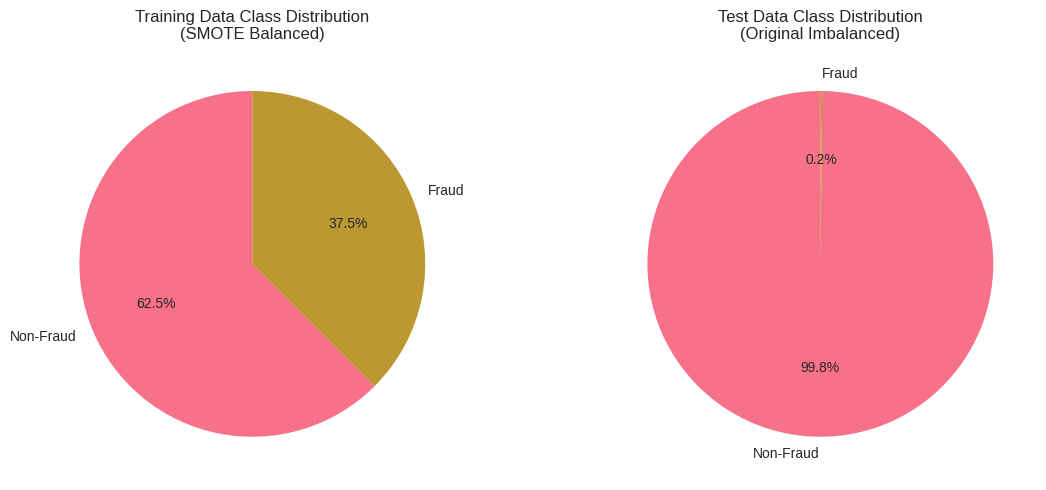

Sample of training data:
       Time        V1        V2        V3        V4        V5        V6  \
0  0.521545 -0.104179  0.468521 -0.335128 -0.356340  0.804377 -0.667681   
1 -0.346063  0.605455 -0.470903  0.191616 -0.358294 -0.640255 -0.333752   
2  0.251245  0.172511 -0.242270  0.921499 -0.424739 -1.037679 -0.086651   
3  1.505202  1.039022 -0.236058 -1.683033 -0.510496  1.724685  2.492682   
4  1.270533  1.018355 -0.207722 -0.340471  0.240132 -0.256244 -0.075733   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.721737 -0.108625  0.061773  ... -0.481981 -1.159004  0.552610  0.765367   
1 -0.307755 -0.114204 -0.668254  ...  0.136557  0.242823 -0.139442  0.194031   
2 -0.640178 -0.095123 -0.744731  ... -0.272805  0.243908  0.024354 -0.158550   
3 -0.378643  0.660996  0.366295  ... -0.392727 -1.156216  0.599909  1.153469   
4 -0.462688 -0.008019  1.142930  ...  0.382450  1.453624  0.142557  1.086039   

        V25       V26       V27       V28  

In [5]:
# Visualize class distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training data distribution
train_counts = train_df[class_label].value_counts()
axes[0].pie(train_counts.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Training Data Class Distribution\n(SMOTE Balanced)')

# Test data distribution
test_counts = test_df[class_label].value_counts()
axes[1].pie(test_counts.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Test Data Class Distribution\n(Original Imbalanced)')

plt.tight_layout()
plt.show()

# Display first few rows
print("Sample of training data:")
print(train_df.head())


## 2. Data Preprocessing for FT-Transformer

Preparing the data for TabNet training including feature separation and encoding.


In [6]:
# Data preprocessing for TabNet
def preprocess_data(train_df, test_df):
    """
    Preprocess data for TabNet training

    Returns:
        X_train, y_train, X_test, y_test, cat_idxs, cat_dims
    """
    import json

    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    print(f"Loaded metadata: {metadata}")

    # Separate features and target
    feature_cols = [col for col in train_df.columns if col != class_label]

    X_train = train_df[feature_cols].copy()
    y_train = train_df[class_label].values.astype(int)

    X_test = test_df[feature_cols].copy()
    y_test = test_df[class_label].values.astype(int)

    print(f"Feature columns: {len(feature_cols)}")
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")

    categorical_cols = []
    numerical_cols = [col for col in feature_cols if col not in categorical_cols]


    # Get categorical info from metadata but verify against current feature order
    metadata_features = metadata.get('feature_columns', [])

    print(f"Metadata feature order: {metadata_features}")
    print(f"Current feature order: {feature_cols}")

    # Convert DataFrames to numpy arrays for TabNet (required)
    X_train = X_train.values.astype(np.float32)
    X_test = X_test.values.astype(np.float32)

    print(f"\nConverted to numpy arrays for TabNet compatibility")
    print(f"X_train type: {type(X_train)}, shape: {X_train.shape}")
    print(f"X_test type: {type(X_test)}, shape: {X_test.shape}")

    return X_train, y_train, X_test, y_test, feature_cols, numerical_cols

# Preprocess the data
X_train, y_train, X_test, y_test, feature_names, numerical_cols = preprocess_data(train_df, test_df)

print(f"\nFinal shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")
print(f"Class distribution in y_train: {np.bincount(y_train)}")
print(f"Class distribution in y_test: {np.bincount(y_test)}")


Loaded metadata: {'original_dataset_shape': [284807, 31], 'feature_columns': ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'], 'target_column': 'Class', 'scaling_method': 'StandardScaler', 'balancing_method': 'smote', 'train_test_split_ratio': '80:20', 'random_seed': 42, 'class_distribution_original': {'non_fraud': 284315, 'fraud': 492, 'imbalance_ratio': 577.8760162601626}, 'class_distribution_train_final': {'non_fraud': 255883, 'fraud': 153529, 'imbalance_ratio': 1.6666753512365742, 'sampling_technique': 'smote'}, 'class_distribution_test_final': {'non_fraud': 28432, 'fraud': 49, 'imbalance_ratio': 580.2448979591836, 'note': 'Original imbalanced distribution for realistic evaluation'}}
Feature columns: 30
Training samples: 409412
Test samples: 28481
Metadata feature order: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 

In [7]:
# Create validation split from training data
X_train_df = pd.DataFrame(X_train, columns=feature_names)
y_train_df = pd.DataFrame(y_train, columns=[class_label])

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_df, y_train_df,
    test_size=0.1,
    random_state=random_seed,
    stratify=y_train_df
)

print(f"Training split: {X_train_split.shape}")
print(f"Validation split: {X_val.shape}")

Training split: (368470, 30)
Validation split: (40942, 30)


## 3. FT-Transformer Model Definition and Training

Building and training the TabNet classifier with optimized hyperparameters for fraud detection.


In [44]:
class FraudFTTransformer:
    def __init__(self, n_num_features, n_cat_features, n_cont_features, cat_cardinalities,
                 device=None, seed: int = 42, **model_params):
        # Use global device if not specified
        if device is None:
            device = globals().get('device', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        self.device = device
        self.seed = seed

        # Set seeds for reproducibility across libs
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

        print(f"Initializing FraudFTTransformer on device: {self.device}")

        default_params = {
            'n_blocks':3,
            'd_block': 224,
            'attention_n_heads': 8,
            'attention_dropout': 0.1,
            'ffn_d_hidden': None,
            'ffn_d_hidden_multiplier': 5/4,
            'ffn_dropout': 0.1,
            'residual_dropout': 0.0,
        }

        # Update with provided parameters
        default_params.update(model_params)
        self.model_params = default_params

        print(f"Model parameters: {self.model_params}")

        # Model configuration optimized for fraud detection
        self.model = FTTransformer(
            n_cont_features=n_cont_features,
            cat_cardinalities=cat_cardinalities,
            d_out=2,
            **default_params
        ).to(self.device)

        fraud_count = (y_train_split == 1).sum()
        non_fraud_count = (y_train_split == 0).sum()

        self.criterion = nn.CrossEntropyLoss().to(self.device)

        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=0.0003,
            weight_decay=1e-3
        )

        # Ensure DataLoader worker determinism - use CPU generator for reproducibility
        self.generator = torch.Generator().manual_seed(self.seed)

        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=5, factor=0.7, min_lr=1e-6
        )

        # Print model info
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"Model parameters: {total_params:,} total, {trainable_params:,} trainable")

        if torch.cuda.is_available() and self.device.type == 'cuda':
            print(f"GPU memory allocated: {torch.cuda.memory_allocated(self.device) / 1024**2:.1f} MB")


    def fit(self, X_num, y, X_val_num=None, y_val=None,
            epochs=100, batch_size=512, patience=20):

        X_cat = None

        pin_memory = torch.cuda.is_available() and self.device.type == 'cuda'
        # Use num_workers=0 in Jupyter to avoid multiprocessing issues
        num_workers = 0

        print(f"DataLoader config: pin_memory={pin_memory}, num_workers={num_workers}")

        # Create data loaders with CUDA optimizations
        train_dataset = TensorDataset(
            torch.FloatTensor(X_num),
            torch.LongTensor(y)
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            generator=self.generator,
            pin_memory=pin_memory,
            num_workers=num_workers
        )

        if X_val_num is not None:
            val_dataset = TensorDataset(
                torch.FloatTensor(X_val_num),
                torch.LongTensor(y_val)
            )

            val_loader = DataLoader(
                val_dataset,
                batch_size=batch_size,
                pin_memory=pin_memory,
                num_workers=num_workers
            )

        # Training loop
        best_val_loss = float('inf')
        patience_counter = 0
        history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_auc': [], 'val_accuracy': []}

        print(f"Starting training for {epochs} epochs on {self.device}")

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0

            train_correct = 0
            train_total = 0

            for batch_idx, (batch_num, batch_y) in enumerate(train_loader):
                # Move tensors to device with non_blocking for CUDA efficiency
                batch_num = batch_num.to(self.device, non_blocking=True)
                batch_y = batch_y.to(self.device, non_blocking=True)

                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(batch_num, None)
                loss = self.criterion(outputs, batch_y.squeeze())

                # Backward pass
                loss.backward()

                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                self.optimizer.step()
                train_loss += loss.item()

                # Calculate training accuracy
                _, predicted = torch.max(outputs.data, 1)
                train_total += batch_y.size(0)
                train_correct += (predicted == batch_y.squeeze()).sum().item()

                # Clear cache periodically on CUDA to prevent memory issues
                if torch.cuda.is_available() and batch_idx % 100 == 0:
                    torch.cuda.empty_cache()

            # Calculate and store training accuracy
            train_accuracy = train_correct / train_total
            history['train_accuracy'].append(train_accuracy)

            # Validation phase
            if X_val_num is not None:
                val_loss, val_auc, val_accuracy = self._validate(val_loader)
                history['val_loss'].append(val_loss)
                history['val_auc'].append(val_auc)
                history['val_accuracy'].append(val_accuracy)

                # Learning rate scheduling
                self.scheduler.step(val_loss)

                # Early stopping tracking
                improved = val_loss < best_val_loss
                if improved:
                    best_val_loss = val_loss
                    patience_counter = 0
                    # Save a deep copy of the best state dict
                    best_state_dict = copy.deepcopy(self.model.state_dict())
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

                # Print statement with accuracy
                print(f"Epoch {epoch}: Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f} | "
                      f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}, Val Acc: {val_accuracy:.4f}")


            history['train_loss'].append(train_loss/len(train_loader))

        # Restore best model weights if available
        if 'best_state_dict' in locals() and best_state_dict is not None:
            self.model.load_state_dict(best_state_dict)
            self.best_val_loss = best_val_loss
            self.best_state_dict = best_state_dict
        else:
            print("No validation data provided - using final model weights")
            self.best_val_loss = None
            self.best_state_dict = None

        return history

    def _validate(self, val_loader):
        self.model.eval()
        val_loss = 0
        all_probs = []
        all_labels = []

        # Track validation accuracy
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_num, batch_y in val_loader:
                # Move tensors to device with non_blocking for CUDA efficiency
                batch_num = batch_num.to(self.device, non_blocking=True)
                batch_y = batch_y.to(self.device, non_blocking=True)

                outputs = self.model(batch_num, None)
                loss = self.criterion(outputs, batch_y.squeeze())
                val_loss += loss.item()

                probs = torch.softmax(outputs, dim=1)[:, 1]
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())

                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y.squeeze()).sum().item()

        val_accuracy = val_correct / val_total
        val_auc = roc_auc_score(all_labels, all_probs)
        return val_loss/len(val_loader), val_auc, val_accuracy

    def predict_proba(self, X_num, batch_size=512):
        self.model.eval()
        all_probs = []

        # CUDA optimizations for inference
        pin_memory = torch.cuda.is_available() and self.device.type == 'cuda'

        dataset = TensorDataset(
            torch.FloatTensor(X_num)
        )
        loader = DataLoader(
            dataset,
            batch_size=batch_size,
            pin_memory=pin_memory,
            num_workers=0
        )

        with torch.no_grad():
            for batch in loader:
                batch_num = batch[0].to(self.device, non_blocking=True)

                outputs = self.model(batch_num, None)
                probs = torch.softmax(outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())

        return np.array(all_probs)

    def get_memory_usage(self):
        """Get current memory usage information"""
        if torch.cuda.is_available() and self.device.type == 'cuda':
            allocated = torch.cuda.memory_allocated(self.device) / 1024**2
            cached = torch.cuda.memory_reserved(self.device) / 1024**2
            return f"GPU Memory - Allocated: {allocated:.1f} MB, Cached: {cached:.1f} MB"
        else:
            return "CPU mode - no GPU memory tracking"

    def cleanup_memory(self):
        """Clean up CUDA memory and force garbage collection"""
        import gc

        # Force garbage collection to clean up any lingering DataLoader references
        gc.collect()

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print("CUDA cache cleared")

        print("Memory cleanup completed")

    def save_model(self, filepath):
        """Save the best model state and configuration"""
        save_dict = {
            'model_state_dict': self.best_state_dict if hasattr(self, 'best_state_dict') and self.best_state_dict is not None else self.model.state_dict(),
            'model_params': self.model_params,
            'best_val_loss': getattr(self, 'best_val_loss', None),
            'device': str(self.device),
            'seed': self.seed
        }
        torch.save(save_dict, filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """Load model state and configuration"""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.best_val_loss = checkpoint.get('best_val_loss', None)
        self.best_state_dict = checkpoint['model_state_dict']
        print(f"Model loaded from {filepath}")
        if self.best_val_loss is not None:
            print(f"Best validation loss: {self.best_val_loss:.4f}")

    def ensure_best_model(self):
        """Ensure the model is using the best weights"""
        if hasattr(self, 'best_state_dict') and self.best_state_dict is not None:
            self.model.load_state_dict(self.best_state_dict)
            print("Using best model weights for evaluation")
        else:
            print("No best model weights available, using current weights")

X_train_num = X_train_split[numerical_cols].reset_index(drop=True).to_numpy()
y_train = y_train_split.reset_index(drop=True).to_numpy()

X_val_num = X_val[numerical_cols].reset_index(drop=True).to_numpy()
y_val_val = y_val.reset_index(drop=True).to_numpy()

categorical_cols = []
cat_dims = []

# Usage - model will automatically use the global device (CUDA if available)
ft_model = FraudFTTransformer(
    n_num_features=len(feature_names),
    n_cat_features=len(categorical_cols),
    n_cont_features=len(numerical_cols),
    cat_cardinalities=cat_dims,
    device=device,
    seed=12
)

# Optimize batch size based on device
if torch.cuda.is_available() and device.type == 'cuda':
    # Larger batch size for CUDA
    batch_size = 4096
    print(f"Using CUDA optimized batch size: {batch_size}")
else:
    # Smaller batch size for CPU
    batch_size = 1024
    print(f"Using CPU batch size: {batch_size}")

print(f"{ft_model.get_memory_usage()}")

# Train the model
history = ft_model.fit(
    X_train_num, y_train,
    X_val_num, y_val_val,
    epochs=35, batch_size=batch_size, patience=10
)

# Clean up memory after training
ft_model.cleanup_memory()
print(f"After training: {ft_model.get_memory_usage()}")

# Save the initial model
# ft_model.save_model('../models/ft_transformer_initial.pth')

Initializing FraudFTTransformer on device: cuda
Model parameters: {'n_blocks': 3, 'd_block': 224, 'attention_n_heads': 8, 'attention_dropout': 0.1, 'ffn_d_hidden': None, 'ffn_d_hidden_multiplier': 1.25, 'ffn_dropout': 0.1, 'residual_dropout': 0.0}
Model parameters: 1,188,434 total, 1,188,434 trainable
GPU memory allocated: 91.2 MB
Using CUDA optimized batch size: 4096
GPU Memory - Allocated: 68.5 MB, Cached: 312.0 MB
DataLoader config: pin_memory=True, num_workers=0
Starting training for 35 epochs on cuda
Epoch 0: Train Loss: 0.0868, Train Acc: 0.9640 | Val Loss: 0.0168, Val AUC: 0.9997, Val Acc: 0.9942
Epoch 1: Train Loss: 0.0145, Train Acc: 0.9952 | Val Loss: 0.0098, Val AUC: 0.9998, Val Acc: 0.9971
Epoch 2: Train Loss: 0.0075, Train Acc: 0.9979 | Val Loss: 0.0058, Val AUC: 0.9999, Val Acc: 0.9987
Epoch 3: Train Loss: 0.0061, Train Acc: 0.9983 | Val Loss: 0.0041, Val AUC: 0.9999, Val Acc: 0.9990
Epoch 4: Train Loss: 0.0043, Train Acc: 0.9989 | Val Loss: 0.0050, Val AUC: 0.9999, Val A

{'train_loss': [0.08678389513451192, 0.014470336932895912, 0.0074893368718524774, 0.006100589907469435, 0.004254313601672443, 0.003457104642358091, 0.0032851328691726345, 0.0031223284701506295, 0.00270492080566732, 0.003220325148302234, 0.0026586677167668112, 0.0030437021726457815, 0.0023854082922399457, 0.0022674963308317174, 0.0017409483001554489, 0.0014708743840553022, 0.0013350207366278886, 0.0019360858122430121, 0.0013760953308923894, 0.0013144086057663015, 0.0009297014857616483, 0.0016812978024568616, 0.0012681194687805448, 0.0012766818579014701, 0.0014350897876688072, 0.0008535938539150973, 0.0010650813726695357, 0.0008588631674582656, 0.0009418695882939371, 0.0012687746913595927, 0.0007622403079747326, 0.00039565989007112675, 0.00025992915377881016, 0.0005540140947333486, 0.00028966988486192553], 'train_accuracy': [0.9640024968111379, 0.9951827828588488, 0.997902135859093, 0.9983146524818846, 0.9989117160148723, 0.9991966781556164, 0.9992075338562162, 0.9992346731077157, 0.9993

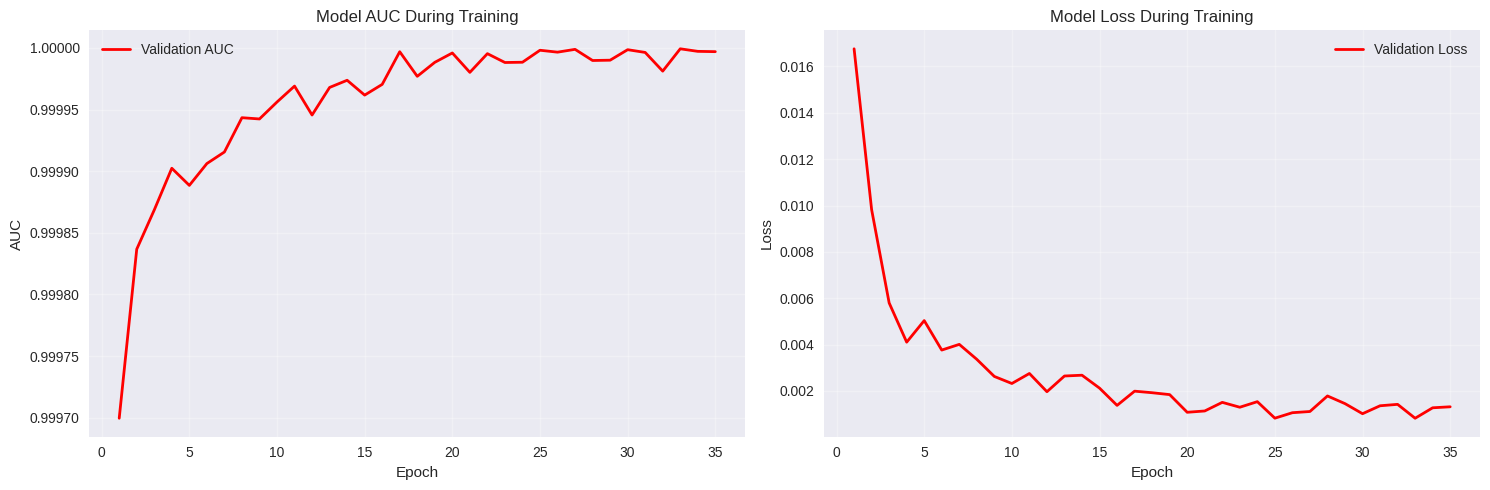

Final Training Metrics:
Validation AUC: 1.0000
Validation Accuracy: 0.0013


In [45]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    print(history)
    # Plot loss
    epochs = range(1, len(history['val_auc']) + 1)

    # axes[0].plot(epochs, history['train_auc'], 'b-', label='Training AUC', linewidth=2)
    axes[0].plot(epochs, history['val_auc'], 'r-', label='Validation AUC', linewidth=2)
    axes[0].set_title('Model AUC During Training')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('AUC')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot accuracy
    # axes[1].plot(epochs, history['train_accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[1].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[1].set_title('Model Loss During Training')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Print final metrics
print("Final Training Metrics:")
# print(f"Training AUC: {history['train_auc'][-1]:.4f}")
print(f"Validation AUC: {history['val_auc'][-1]:.4f}")
# print(f"Training Accuracy: {history['train_accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history['val_loss'][-1]:.4f}")


## 5. Model Evaluation on Original Test Set (Using Best Model)

**Important**: This evaluation uses the best model found during grid search, ensuring optimal performance on the test set.

In [46]:
# Ensure we're using the best model for evaluation
print("Preparing for evaluation with the best model...")
ft_model.ensure_best_model()

# Verify model state
if hasattr(ft_model, 'best_val_loss') and ft_model.best_val_loss is not None:
    print(f"Using best model with validation loss: {ft_model.best_val_loss:.4f}")
else:
    print("Using current model weights (no validation-based best model available)")

print(f"Model memory usage: {ft_model.get_memory_usage()}")
print("Ready for test set evaluation!")


Preparing for evaluation with the best model...
Using best model weights for evaluation
Using best model with validation loss: 0.0008
Model memory usage: GPU Memory - Allocated: 86.7 MB, Cached: 192.0 MB
Ready for test set evaluation!


Model Evaluation Utilities
Starting comprehensive evaluation for FTTransformer_Fraud_Classifier
Making predictions...
Calculating performance metrics...
Analyzing confusion matrix...
Analyzing class distributions...
Calculating fraud-specific metrics...
Generating classification report...

CLASSIFICATION REPORT
--------------------------------------------------
              precision    recall  f1-score   support

   Non-Fraud     0.9997    0.9999    0.9998     28432
       Fraud     0.9318    0.8367    0.8817        49

    accuracy                         0.9996     28481
   macro avg     0.9658    0.9183    0.9408     28481
weighted avg     0.9996    0.9996    0.9996     28481

Performing threshold analysis...
Analyzing prediction probabilities...
Generating summary report...

FRAUD DETECTION MODEL EVALUATION REPORT

Model: FTTransformer_Fraud_Classifier
Test Set Size: 28,481 samples
Evaluation Date: 2025-10-21T10:22:33.660778

PERFORMANCE SUMMARY
------------------------------
• O

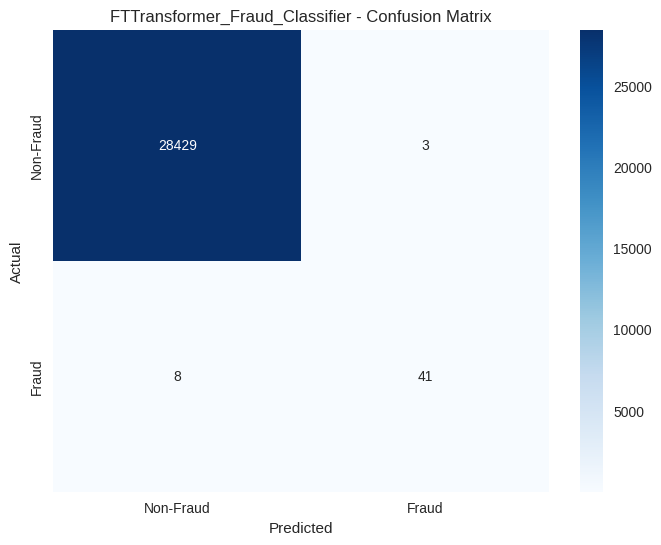

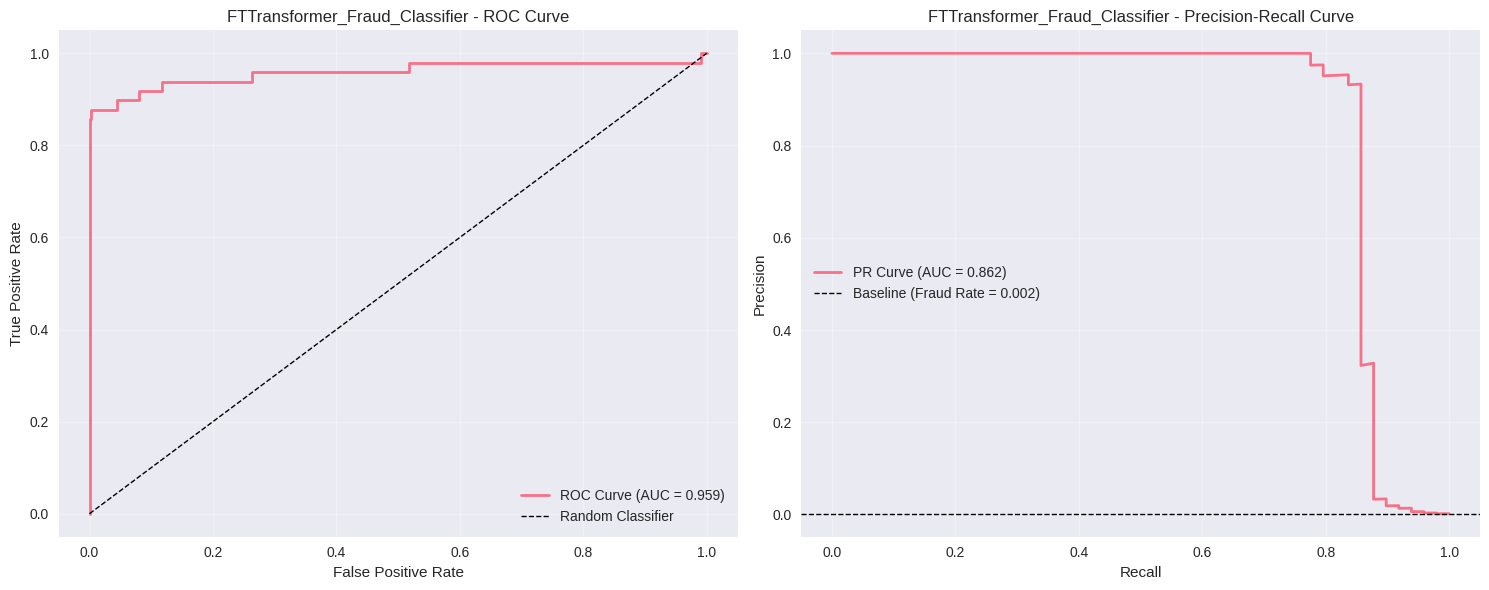

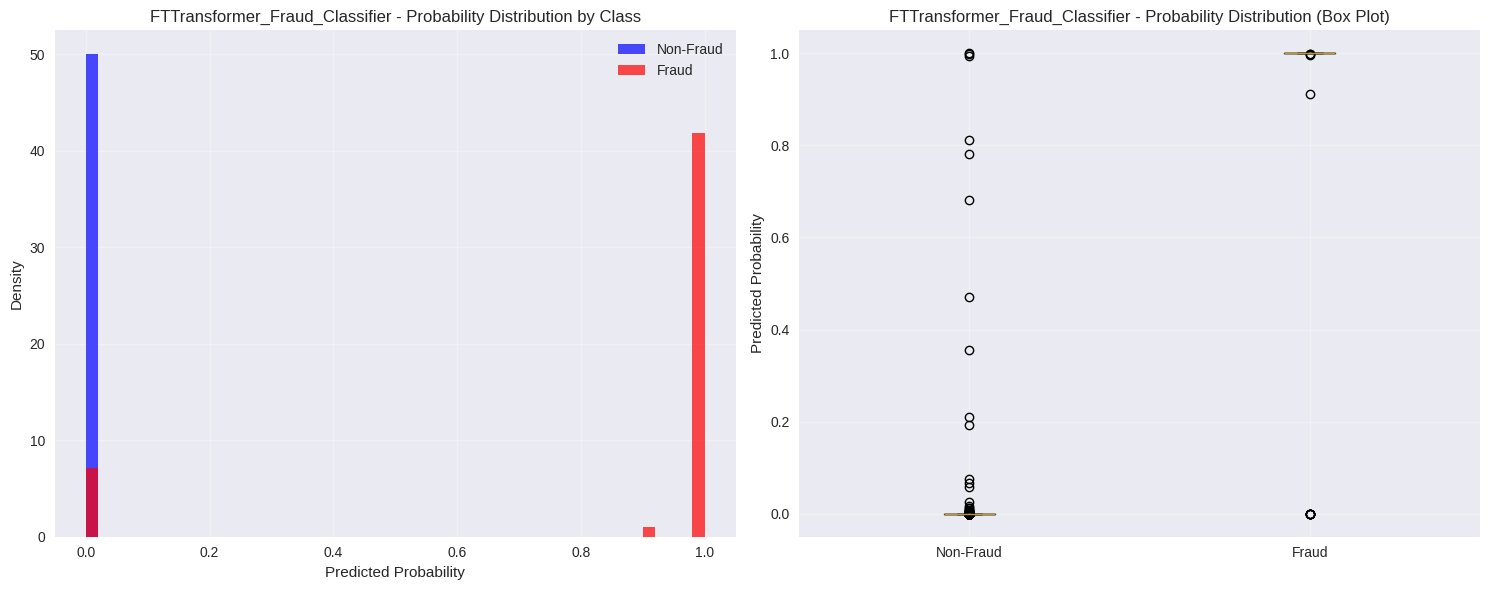


✅ Evaluation completed for FTTransformer_Fraud_Classifier
{'model_name': 'FTTransformer_Fraud_Classifier', 'test_set_size': 28481, 'evaluation_timestamp': '2025-10-21T10:22:33.660778', 'threshold': 0.85, 'basic_metrics': {'accuracy': 0.9996137776061234, 'balanced_accuracy': np.float64(0.9183145894823883), 'precision': 0.9318181818181818, 'recall': 0.8367346938775511, 'f1_score': 0.8817204301075269, 'matthews_corrcoef': np.float64(0.8828085391767327), 'roc_auc': np.float64(0.9588506195950524), 'pr_auc': np.float64(0.8616404360101998)}, 'confusion_analysis': {'confusion_matrix': [[28429, 3], [8, 41]], 'true_negatives': 28429, 'false_positives': 3, 'false_negatives': 8, 'true_positives': 41, 'total_fraud_detected': 41, 'total_fraud_missed': 8, 'false_alarm_rate': np.float64(0.00010551491277433877), 'true_negative_rate': np.float64(0.9998944850872257)}, 'class_distribution': {'test_set': {'non_fraud': 28432, 'fraud': 49, 'fraud_percentage': 0.17204452090867595}, 'predictions': {'predicted

In [48]:
"""
Comprehensive Model Evaluation for Fraud Detection
"""
def comprehensive_model_test(
    model,
    X_test: Union[np.ndarray, pd.DataFrame],
    y_test: Union[np.ndarray, pd.Series],
    model_name: str = "Model",
    feature_names: Optional[list] = None,
    class_names: Optional[list] = None,
    threshold: float = 0.5,
    save_results: bool = True,
    results_dir: str = "../results/",
    plot_results: bool = True,
    detailed_report: bool = True
) -> Dict[str, Any]:
    """
    Comprehensive testing function for fraud detection models.
    """

    print(f"Starting comprehensive evaluation for {model_name}")
    print("="*60)

    # Set default class names
    if class_names is None:
        class_names = ['Non-Fraud', 'Fraud']

    # Initialize results dictionary
    results = {
        'model_name': model_name,
        'test_set_size': len(y_test),
        'evaluation_timestamp': datetime.now().isoformat(),
        'threshold': threshold
    }

    # 1. Make predictions
    print("Making predictions...")
    try:
        # Get probability predictions
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)
            if y_pred_proba.shape[1] == 2:
                y_pred_proba_fraud = y_pred_proba[:, 1]  # Probability of fraud
            else:
                y_pred_proba_fraud = y_pred_proba.flatten()
        else:
            raise AttributeError("Model must have predict_proba method")

        # Get binary predictions
        if hasattr(model, 'predict'):
            y_pred = model.predict(X_test)
        else:
            y_pred = (y_pred_proba_fraud >= threshold).astype(int)

    except Exception as e:
        print(f"Error making predictions: {e}")
        return {'error': str(e)}

    # 2. Calculate basic metrics
    print("Calculating performance metrics...")

    # Basic classification metrics
    basic_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'matthews_corrcoef': matthews_corrcoef(y_test, y_pred)
    }

    # ROC and PR metrics
    try:
        basic_metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba_fraud)
        basic_metrics['pr_auc'] = average_precision_score(y_test, y_pred_proba_fraud)
    except Exception as e:
        print(f"Warning: Could not calculate AUC metrics: {e}")
        basic_metrics['roc_auc'] = None
        basic_metrics['pr_auc'] = None

    results['basic_metrics'] = basic_metrics

    # 3. Confusion Matrix Analysis
    print("Analyzing confusion matrix...")
    cm = confusion_matrix(y_test, y_pred)

    # Calculate confusion matrix components
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)

    confusion_analysis = {
        'confusion_matrix': cm.tolist(),
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp),
        'total_fraud_detected': int(tp),
        'total_fraud_missed': int(fn),
        'false_alarm_rate': fp / (fp + tn) if (fp + tn) > 0 else 0,
        'true_negative_rate': tn / (tn + fp) if (tn + fp) > 0 else 0
    }

    results['confusion_analysis'] = confusion_analysis

    # 4. Class Distribution Analysis
    print("Analyzing class distributions...")

    class_distribution = {
        'test_set': {
            'non_fraud': int((y_test == 0).sum()),
            'fraud': int((y_test == 1).sum()),
            'fraud_percentage': float((y_test == 1).mean() * 100)
        },
        'predictions': {
            'predicted_non_fraud': int((y_pred == 0).sum()),
            'predicted_fraud': int((y_pred == 1).sum()),
            'predicted_fraud_percentage': float((y_pred == 1).mean() * 100)
        }
    }

    results['class_distribution'] = class_distribution

    # 5. Fraud Detection Specific Metrics
    print("Calculating fraud-specific metrics...")

    fraud_metrics = {
        'fraud_detection_rate': tp / (tp + fn) if (tp + fn) > 0 else 0,  # Same as recall
        'fraud_precision': tp / (tp + fp) if (tp + fp) > 0 else 0,       # Same as precision
        'false_positive_rate': fp / (fp + tn) if (fp + tn) > 0 else 0,
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,           # True negative rate
        'negative_predictive_value': tn / (tn + fn) if (tn + fn) > 0 else 0,
        'fraud_cases_total': int((y_test == 1).sum()),
        'fraud_cases_detected': int(tp),
        'fraud_cases_missed': int(fn)
    }

    results['fraud_metrics'] = fraud_metrics

    # 5.5. Classification Report
    print("Generating classification report...")

    # Generate classification report
    class_report = classification_report(
        y_test, y_pred,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )

    # Store classification report
    results['classification_report'] = class_report

    # Print formatted classification report
    print("\nCLASSIFICATION REPORT")
    print("-" * 50)
    class_report_str = classification_report(
        y_test, y_pred,
        target_names=class_names,
        zero_division=0,
        digits=4
    )
    print(class_report_str)

    # 6. Threshold Analysis
    if detailed_report:
        print("Performing threshold analysis...")
        threshold_analysis = analyze_thresholds(y_test, y_pred_proba_fraud)
        results['threshold_analysis'] = threshold_analysis

    # 7. Probability Distribution Analysis
    print("Analyzing prediction probabilities...")
    prob_analysis = analyze_probability_distributions(y_test, y_pred_proba_fraud)
    results['probability_analysis'] = prob_analysis


    # 9. Feature importance (if available)
    if hasattr(model, 'feature_importances_') and feature_names is not None:
        print("Extracting feature importance...")
        feature_importance = extract_feature_importance(model, feature_names)
        results['feature_importance'] = feature_importance

    # 10. Generate summary report
    print("Generating summary report...")
    summary = generate_summary_report(results)
    results['summary_report'] = summary

    # 11. Print summary
    print_evaluation_summary(results)

    # 12. Generate visualizations
    if plot_results:
        print("Generating visualizations...")
        plots = generate_evaluation_plots(
            y_test, y_pred, y_pred_proba_fraud,
            model_name, class_names, save_results, results_dir
        )
        results['plots_generated'] = plots

    # # 11. Save results
    # if save_results:
    #     print("Saving results...")
    #     save_evaluation_results(results, results_dir, model_name)


    print(f"\n✅ Evaluation completed for {model_name}")
    print("="*60)

    return results

def analyze_thresholds(y_true: np.ndarray, y_pred_proba: np.ndarray,
                      n_thresholds: int = 100) -> Dict[str, Any]:
    """
    Analyze performance across different classification thresholds.
    """

    thresholds = np.linspace(0, 1, n_thresholds)
    threshold_metrics = []

    for threshold in thresholds:
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)

        if len(np.unique(y_pred_thresh)) > 1:  # Avoid issues with all same predictions
            precision = precision_score(y_true, y_pred_thresh, zero_division=0)
            recall = recall_score(y_true, y_pred_thresh, zero_division=0)
            f1 = f1_score(y_true, y_pred_thresh, zero_division=0)
        else:
            precision = recall = f1 = 0

        threshold_metrics.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

    # Find optimal threshold based on F1 score
    best_f1_idx = np.argmax([m['f1_score'] for m in threshold_metrics])
    optimal_threshold = threshold_metrics[best_f1_idx]

    return {
        'threshold_metrics': threshold_metrics,
        'optimal_threshold': optimal_threshold,
        'optimal_threshold_value': optimal_threshold['threshold']
    }


def analyze_probability_distributions(y_true: np.ndarray, y_pred_proba: np.ndarray) -> Dict[str, Any]:
    """
    Analyze the distribution of predicted probabilities for each class.
    """

    fraud_probs = y_pred_proba[y_true == 1]
    non_fraud_probs = y_pred_proba[y_true == 0]

    analysis = {
        'fraud_probability_stats': {
            'mean': float(np.mean(fraud_probs)) if len(fraud_probs) > 0 else 0,
            'median': float(np.median(fraud_probs)) if len(fraud_probs) > 0 else 0,
            'std': float(np.std(fraud_probs)) if len(fraud_probs) > 0 else 0,
            'min': float(np.min(fraud_probs)) if len(fraud_probs) > 0 else 0,
            'max': float(np.max(fraud_probs)) if len(fraud_probs) > 0 else 0
        },
        'non_fraud_probability_stats': {
            'mean': float(np.mean(non_fraud_probs)) if len(non_fraud_probs) > 0 else 0,
            'median': float(np.median(non_fraud_probs)) if len(non_fraud_probs) > 0 else 0,
            'std': float(np.std(non_fraud_probs)) if len(non_fraud_probs) > 0 else 0,
            'min': float(np.min(non_fraud_probs)) if len(non_fraud_probs) > 0 else 0,
            'max': float(np.max(non_fraud_probs)) if len(non_fraud_probs) > 0 else 0
        }
    }

    # Calculate probability separation
    if len(fraud_probs) > 0 and len(non_fraud_probs) > 0:
        separation_score = np.mean(fraud_probs) - np.mean(non_fraud_probs)
        analysis['probability_separation_score'] = float(separation_score)
    else:
        analysis['probability_separation_score'] = 0.0

    return analysis


def generate_evaluation_plots(y_true: np.ndarray, y_pred: np.ndarray, y_pred_proba: np.ndarray,
                            model_name: str, class_names: list, save_plots: bool = True,
                            save_dir: str = "../results/") -> list:
    """
    Generate comprehensive evaluation plots.
    """

    plots_generated = []

    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")

    # 1. Confusion Matrix Heatmap
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(f'{model_name} - Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    if save_plots:
        plt.savefig(f"{save_dir}{model_name}_confusion_matrix.png", dpi=300, bbox_inches='tight')
        plots_generated.append(f"{model_name}_confusion_matrix.png")
    plt.show()

    # 2. ROC Curve and PR Curve
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # ROC Curve
    try:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = roc_auc_score(y_true, y_pred_proba)

        axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
        axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title(f'{model_name} - ROC Curve')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
    except Exception as e:
        axes[0].text(0.5, 0.5, f'ROC Curve Error: {str(e)}', ha='center', va='center')

    # Precision-Recall Curve
    try:
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        pr_auc = average_precision_score(y_true, y_pred_proba)

        axes[1].plot(recall, precision, linewidth=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
        axes[1].axhline(y=np.mean(y_true), color='k', linestyle='--', linewidth=1,
                       label=f'Baseline (Fraud Rate = {np.mean(y_true):.3f})')
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].set_title(f'{model_name} - Precision-Recall Curve')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    except Exception as e:
        axes[1].text(0.5, 0.5, f'PR Curve Error: {str(e)}', ha='center', va='center')

    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{save_dir}{model_name}_roc_pr_curves.png", dpi=300, bbox_inches='tight')
        plots_generated.append(f"{model_name}_roc_pr_curves.png")
    plt.show()

    # 3. Probability Distribution Plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Histogram of probabilities by class
    fraud_probs = y_pred_proba[y_true == 1]
    non_fraud_probs = y_pred_proba[y_true == 0]

    axes[0].hist(non_fraud_probs, bins=50, alpha=0.7, label='Non-Fraud', color='blue', density=True)
    axes[0].hist(fraud_probs, bins=50, alpha=0.7, label='Fraud', color='red', density=True)
    axes[0].set_xlabel('Predicted Probability')
    axes[0].set_ylabel('Density')
    axes[0].set_title(f'{model_name} - Probability Distribution by Class')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Box plot of probabilities by class
    prob_data = [non_fraud_probs, fraud_probs]
    axes[1].boxplot(prob_data, labels=class_names)
    axes[1].set_ylabel('Predicted Probability')
    axes[1].set_title(f'{model_name} - Probability Distribution (Box Plot)')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{save_dir}{model_name}_probability_distributions.png", dpi=300, bbox_inches='tight')
        plots_generated.append(f"{model_name}_probability_distributions.png")
    plt.show()

    return plots_generated


def extract_feature_importance(model, feature_names: list) -> Dict[str, Any]:
    """
    Extract feature importance from the model if available.
    """

    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
        else:
            return {'error': 'No feature importance available'}

        # Create feature importance dataframe
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)

        # Get top features
        top_features = importance_df.head(10).to_dict('records')

        return {
            'all_features': importance_df.to_dict('records'),
            'top_10_features': top_features,
            'total_features': len(feature_names)
        }

    except Exception as e:
        return {'error': f'Error extracting feature importance: {str(e)}'}


def generate_summary_report(results: Dict[str, Any]) -> str:
    """
    Generate a human-readable summary report.
    """

    basic_metrics = results.get('basic_metrics', {})
    fraud_metrics = results.get('fraud_metrics', {})
    class_dist = results.get('class_distribution', {})

    report = f"""
FRAUD DETECTION MODEL EVALUATION REPORT
{'='*60}

Model: {results.get('model_name', 'Unknown')}
Test Set Size: {results.get('test_set_size', 'Unknown'):,} samples
Evaluation Date: {results.get('evaluation_timestamp', 'Unknown')}

PERFORMANCE SUMMARY
{'-'*30}
• Overall Accuracy: {basic_metrics.get('accuracy', 0):.3f} ({basic_metrics.get('accuracy', 0)*100:.1f}%)
• Balanced Accuracy: {basic_metrics.get('balanced_accuracy', 0):.3f}
• ROC-AUC Score: {basic_metrics.get('roc_auc', 0):.3f}
• PR-AUC Score: {basic_metrics.get('pr_auc', 0):.3f}

FRAUD DETECTION PERFORMANCE
{'-'*30}
• Fraud Detection Rate (Recall): {fraud_metrics.get('fraud_detection_rate', 0):.3f} ({fraud_metrics.get('fraud_detection_rate', 0)*100:.1f}%)
• Fraud Precision: {fraud_metrics.get('fraud_precision', 0):.3f} ({fraud_metrics.get('fraud_precision', 0)*100:.1f}%)
• F1-Score: {basic_metrics.get('f1_score', 0):.3f}
• False Positive Rate: {fraud_metrics.get('false_positive_rate', 0):.3f} ({fraud_metrics.get('false_positive_rate', 0)*100:.1f}%)

FRAUD CASES ANALYSIS
{'-'*30}
• Total Fraud Cases: {fraud_metrics.get('fraud_cases_total', 0):,}
• Fraud Cases Detected: {fraud_metrics.get('fraud_cases_detected', 0):,}
• Fraud Cases Missed: {fraud_metrics.get('fraud_cases_missed', 0):,}
• Fraud Rate in Test Set: {class_dist.get('test_set', {}).get('fraud_percentage', 0):.2f}%

DETAILED CLASSIFICATION REPORT
{'-'*30}"""

    # Add classification report to summary if available
    class_report = results.get('classification_report', {})
    if class_report:
        report += f"""
Class-wise Performance:
• Non-Fraud: Precision={class_report.get('Non-Fraud', {}).get('precision', 0):.3f}, Recall={class_report.get('Non-Fraud', {}).get('recall', 0):.3f}, F1={class_report.get('Non-Fraud', {}).get('f1-score', 0):.3f}
• Fraud: Precision={class_report.get('Fraud', {}).get('precision', 0):.3f}, Recall={class_report.get('Fraud', {}).get('recall', 0):.3f}, F1={class_report.get('Fraud', {}).get('f1-score', 0):.3f}
• Weighted Average: Precision={class_report.get('weighted avg', {}).get('precision', 0):.3f}, Recall={class_report.get('weighted avg', {}).get('recall', 0):.3f}, F1={class_report.get('weighted avg', {}).get('f1-score', 0):.3f}
"""

    report += f"\n{'='*60}"

    return report


def save_evaluation_results(results: Dict[str, Any], save_dir: str, model_name: str):
    """
    Save evaluation results to JSON file.
    """

    import os
    os.makedirs(save_dir, exist_ok=True)

    # Save complete results
    results_file = f"{save_dir}{model_name}_evaluation_results.json"
    with open(results_file, 'w') as f:
        json.dump(results, f, indent=2, default=str)

    # Save summary report
    summary_file = f"{save_dir}{model_name}_evaluation_summary.txt"
    with open(summary_file, 'w') as f:
        f.write(results.get('summary_report', ''))

    print(f"Results saved to: {results_file}")
    print(f"Summary saved to: {summary_file}")


def print_evaluation_summary(results: Dict[str, Any]):
    """
    Print a formatted summary of the evaluation results.
    """

    print(results.get('summary_report', 'No summary available'))

def test_ft_transformer_model(ft_model, X_test_num, X_test_cat, y_test, feature_names=None):
    """
    Convenience function specifically for testing FT-Transformer models.

    Usage:
        results = test_ft_transformer_model(ft_model, X_test_num, X_test_cat, y_test, feature_names)
    """

    # Create a wrapper class for FT-Transformer to match the expected interface
    class FTTransformerWrapper:
        def __init__(self, ft_model):
            self.ft_model = ft_model

        def predict_proba(self, X_test):
            # Assuming X_test is a tuple of (X_num, X_cat)
            if isinstance(X_test, tuple):
                X_num, X_cat = X_test
            else:
                # If single array, need to split appropriately
                raise ValueError("FT-Transformer requires separate numerical and categorical inputs")

            if len(categorical_cols) > 0:
                return self.ft_model.predict_proba_cat(X_num, X_cat)
            else:
                return self.ft_model.predict_proba(X_num)

        def predict(self, X_test):
            proba = self.predict_proba(X_test)
            return (proba[:, 1] >= 0.95).astype(int)

    wrapper = FTTransformerWrapper(ft_model)

    return comprehensive_model_test(
        model=wrapper,
        X_test=(X_test_num, X_test_cat),
        y_test=y_test,
        model_name="FTTransformer_Fraud_Classifier",
        feature_names=feature_names,
        class_names=['Non-Fraud', 'Fraud'],
        threshold=0.85,
        save_results=False,
        results_dir="../results/",
        plot_results=True,
        detailed_report=True
    )


if __name__ == "__main__":
    print("Model Evaluation Utilities")
    X_test = pd.DataFrame(X_test, columns=feature_names)
    X_test_num = X_test[numerical_cols].reset_index(drop=True).to_numpy()
    X_test_cat = X_test[categorical_cols].reset_index(drop=True).to_numpy()
    results = test_ft_transformer_model(ft_model, X_test_num, X_test_cat, y_test, feature_names)
    # print(results)

## 8. Explainable AI (XAI) with SHAP

This section uses SHAP (SHapley Additive exPlanations) to explain the FT-Transformer's predictions:
- Global explanations: overall feature impact via summary plots
- Local explanations: per-transaction explanations for specific predictions

Notes:
- We explain the probability of the positive class (Fraud)
- We use a small background sample for KernelExplainer efficiency
- Features are numerical and standardized; we map indices back to `feature_names`


In [ ]:
# SHAP explanations for FT-Transformer
import shap

# Ensure we have numpy arrays for SHAP
X_train_array = X_train_num  # already numpy
X_test_array = X_test_num

# Define a prediction function that returns P(class=1)
def predict_proba_pos(X):
    # X expected as numpy array
    # Ensure we're in evaluation mode and handle device properly
    ft_model.model.eval()
    with torch.no_grad():
        probs = ft_model.predict_proba(X)
        if probs.ndim == 2 and probs.shape[1] == 2:
            return probs[:, 1]
        return probs.reshape(-1)

# Background sample for KernelExplainer (keep small for speed)
background_size = min(200, X_train_array.shape[0])
rng = np.random.default_rng(random_seed)
background_idx = rng.choice(X_train_array.shape[0], size=background_size, replace=False)
background = X_train_array[background_idx]

# Select a manageable test subset for visualization
explain_size = min(500, X_test_array.shape[0])
explain_idx = rng.choice(X_test_array.shape[0], size=explain_size, replace=False)
X_explain = X_test_array[explain_idx]
y_explain = y_test[explain_idx]

# Build SHAP explainer
explainer = shap.KernelExplainer(model=predict_proba_pos, data=background, link="logit")

# Compute SHAP values (probability output)
# nsamples='auto' balances speed and accuracy
shap_values = explainer.shap_values(X_explain, nsamples='auto')

# Convert to numpy array if needed
shap_values = np.array(shap_values)
if shap_values.ndim == 3:
    # KernelExplainer can return list per class; we used link=logit + scalar output, but guard anyway
    shap_values = shap_values[1]

# Summary plots
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_explain, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_explain, feature_names=feature_names, plot_type='bar', show=False)
plt.tight_layout()
plt.show()

# Local explanations for a few samples
num_local = 3
local_idx = rng.choice(X_explain.shape[0], size=num_local, replace=False)
for i, idx in enumerate(local_idx, 1):
    x = X_explain[idx]
    sv = shap_values[idx]
    prob = float(predict_proba_pos(x.reshape(1, -1))[0])
    print(f"\n=== Local explanation {i} ===")
    print(f"True label: {'Fraud' if y_explain[idx]==1 else 'Non-Fraud'} | Pred P(Fraud): {prob:.4f}")
    shap.force_plot(explainer.expected_value, sv, x, feature_names=feature_names, matplotlib=True)
    plt.show()
